YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


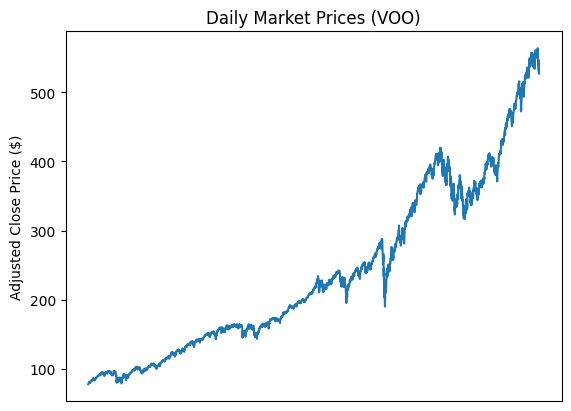

In [1]:
from lbm.datasets.voo import ClosePricesPreprocessor
from matplotlib import pyplot as plt

processor1 = ClosePricesPreprocessor(lookback=1)
train_loader, val_loader, test_loader = processor1.get_loaders()

prices = processor1.dataset.x
plt.plot(prices)
plt.title("Daily Market Prices (VOO)")
# turn off labels on x-axis
plt.ylabel("Adjusted Close Price ($)")
plt.xticks([])
plt.show()

In [2]:
from torch.optim import Adam
from torch.nn import MSELoss
from lbm.devices import get_device
from lbm.workflow.visualized import train_and_validate, ReturnDeltas, DirectionalAccuracy
import numpy as np
import torch
import warnings
from torch import nn

warnings.simplefilter('error')

device = get_device()

def validate_model(model, preprocessor, epochs=50, optimizer=None, 
                   loss_fn=MSELoss()):
    if optimizer is None:
        optimizer = Adam(model.parameters())
    train_loader, val_loader, _ = preprocessor.get_loaders()
    accuracy = DirectionalAccuracy()
    deltas = ReturnDeltas()
    metrics = [accuracy, deltas]
    train_and_validate(model, train_loader, val_loader, optimizer, loss_fn,
                       epochs=epochs, device=device, metrics=metrics)


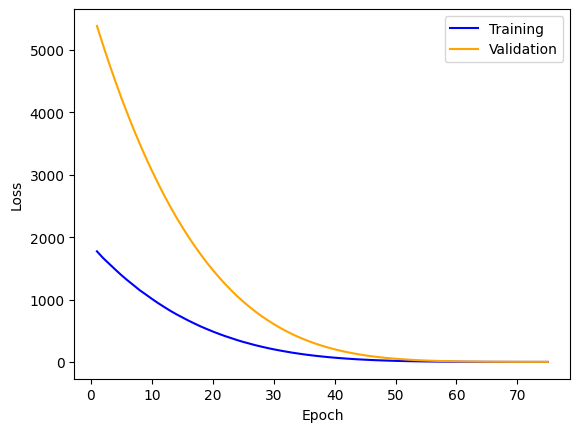

Directional Accuracy: 50.5%


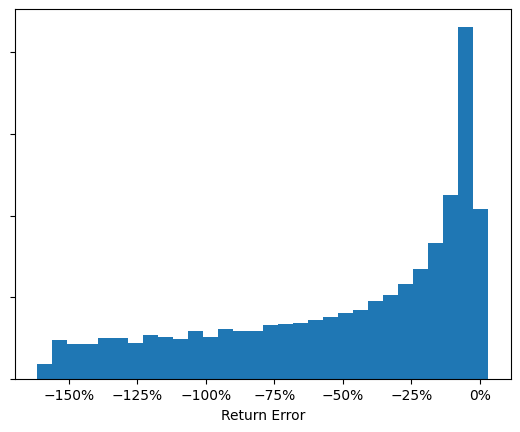

In [3]:
class LinearOneItemForecaster(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.linear(x)
        x = x
        return x

model = LinearOneItemForecaster()

validate_model(model, processor1, epochs=75)

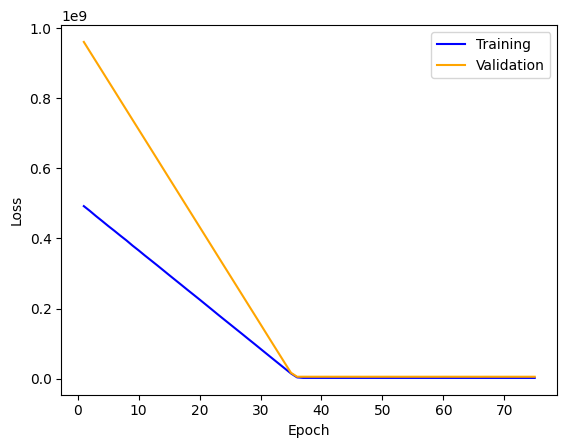

Directional Accuracy: 50.5%


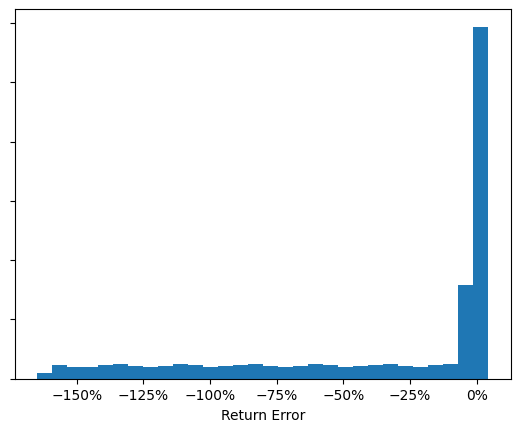

In [4]:
from lbm.loss import MASELoss

model = LinearOneItemForecaster()
loss = MASELoss()

validate_model(model, processor1, epochs=75, loss_fn=loss)

[*********************100%***********************]  1 of 1 completed


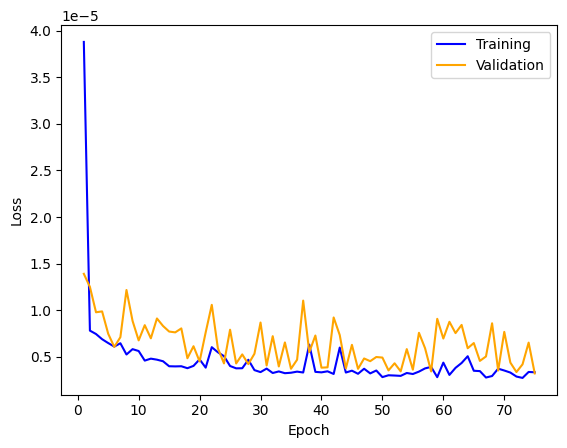

Directional Accuracy: 49.8%


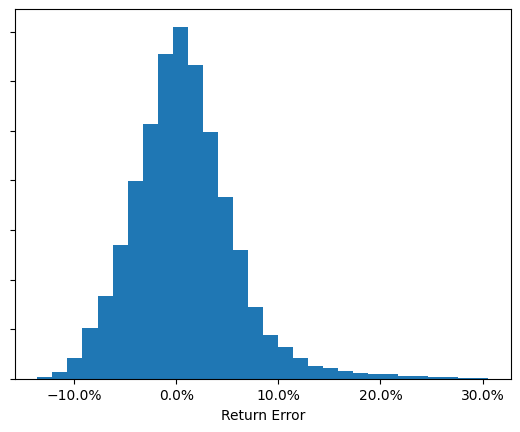

In [9]:
import torch.nn.functional as F

class FFN(torch.nn.Module):
    def __init__(self, lookback):
        super().__init__()
        self.layer_1 = nn.Linear(lookback, 64)
        self.layer_2 = nn.Linear(64, 32)
        self.layer_3 = nn.Linear(32, 32)
        self.layer_4 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)
        x = F.relu(x)
        x = self.layer_4(x)
        return x


lookback = 256
processor256 = ClosePricesPreprocessor(lookback=lookback)
train_loader, val_loader, test_loader = processor1.get_loaders()

model = FFN(lookback)
validate_model(model, processor256, epochs=75, loss_fn=loss)

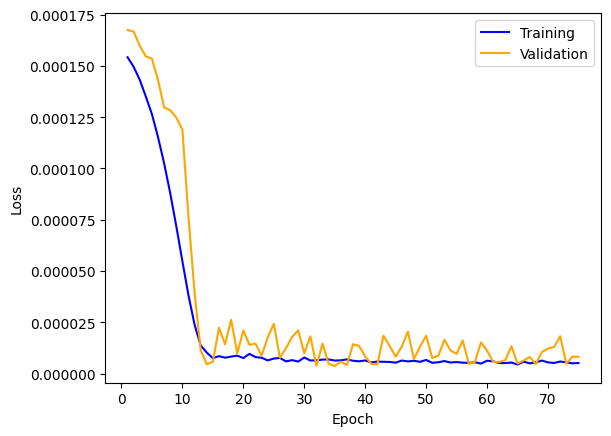

Directional Accuracy: 50.6%


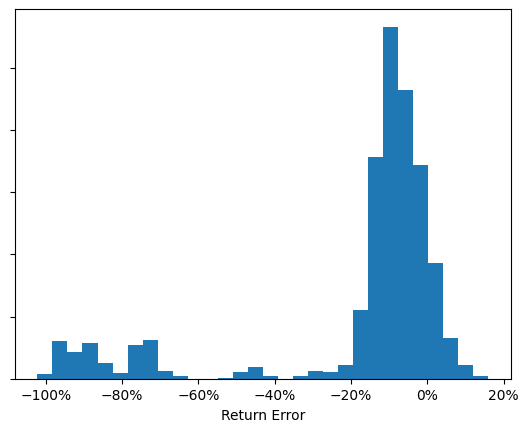

In [11]:
import torch.nn.functional as F

class FFN2(torch.nn.Module):
    def __init__(self, lookback):
        super().__init__()
        self.layer_1 = nn.Linear(lookback, 512)
        self.batch_norm_1 = nn.BatchNorm1d(512)
        self.layer_2 = nn.Linear(512, 256)
        self.batch_norm_2 = nn.BatchNorm1d(256)
        self.layer_3 = nn.Linear(256, 256)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.layer_4 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.layer_1(x)
        x = self.batch_norm_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)
        x = self.layer_3(x)
        x = self.batch_norm_3(x)
        x = F.relu(x)
        x = self.layer_4(x)
        return x

model = FFN2(lookback)
validate_model(model, processor256, epochs=75, loss_fn=loss)